# 3.3 時系列の予測モデルを構築してみよう

## 3.3.7 時系列特徴量を生成しテーブルデータを作ろう
* ラグ特徴量（ラグ1）
* ラグ特徴量（ラグ12）
* ローリング特徴量（1期前までの12ヶ月平均）
* エクスパンディング特徴量（1期前までの平均）
* トレンド特徴量（線形）

### 準備

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load the data
dataset_path = '../AirPassengers.csv'
df = pd.read_csv(dataset_path, index_col='Month', parse_dates=True)

df.head()


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### 特徴量の生成

In [3]:
df_tbl = df.copy()

# ラグ特徴量
df_tbl['lag1'] = df_tbl['Passengers'].shift(1)
df_tbl['lag12'] = df_tbl['Passengers'].shift(12)

# ローリング特徴量(１期前までの12ヶ月平均)
df_tbl['window12'] = df_tbl['Passengers'].rolling(window=12).mean()

# エクスパンディング特徴量（１期前までの平均）
df_tbl['expanding'] = df_tbl['lag1'].expanding().mean()

df_tbl.rename(columns={'Passengers': 'y'}, inplace=True)
df_tbl.head(15)


,y,lag1,lag12,window12,expanding
Month,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,NaN,NaN,112.000000
1949-03-01,132,118.0,NaN,NaN,115.000000
1949-04-01,129,132.0,NaN,NaN,120.666667
1949-05-01,121,129.0,NaN,NaN,122.750000
1949-06-01,135,121.0,NaN,NaN,122.400000
1949-07-01,148,135.0,NaN,NaN,124.500000
1949-08-01,148,148.0,NaN,NaN,127.857143
1949-09-01,136,148.0,NaN,NaN,130.375000


In [4]:
# 欠損を削除
df_tbl = df_tbl.dropna()

df_tbl.head()


,y,lag1,lag12,window12,expanding
Month,,,,,
1950-01-01,115,118.0,112.0,126.916667,126.666667
1950-02-01,126,115.0,118.0,127.583333,125.769231
1950-03-01,141,126.0,132.0,128.333333,125.785714
1950-04-01,135,141.0,129.0,128.833333,126.800000
1950-05-01,125,135.0,121.0,129.166667,127.312500


In [5]:
# トレンド特徴量(線形)
df_tbl['t'] = pd.RangeIndex(start=0,
                            stop=len(df_tbl))

# csvファイルに保存
df_tbl.to_csv('../df_tbl.csv')
df_tbl


,y,lag1,lag12,window12,expanding,t
Month,,,,,,
1950-01-01,115,118.0,112.0,126.916667,126.666667,0
1950-02-01,126,115.0,118.0,127.583333,125.769231,1
1950-03-01,141,126.0,132.0,128.333333,125.785714,2
1950-04-01,135,141.0,129.0,128.833333,126.800000,3
1950-05-01,125,135.0,121.0,129.166667,127.312500,4
...,...,...,...,...,...,...
1960-08-01,606,622.0,559.0,463.333333,273.136691,127
1960-09-01,508,606.0,463.0,467.083333,275.514286,128
1960-10-01,461,508.0,407.0,471.583333,277.163121,129


## 3.3.9 線形回帰で予測モデルを構築（すべての変数利用）

### 準備

In [6]:
import pandas as pd
import numpy as np
import datetime

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima.model_selection import train_test_split

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定
plt.rcParams['font.size'] = 14 #フォントサイズ


In [7]:
dataset_path = '../df_tbl.csv'
df = pd.read_csv(dataset_path, index_col='Month', parse_dates=True)

df.head()


,y,lag1,lag12,window12,expanding,t
Month,,,,,,
1950-01-01,115,118.0,112.0,126.916667,126.666667,0
1950-02-01,126,115.0,118.0,127.583333,125.769231,1
1950-03-01,141,126.0,132.0,128.333333,125.785714,2
1950-04-01,135,141.0,129.0,128.833333,126.800000,3
1950-05-01,125,135.0,121.0,129.166667,127.312500,4


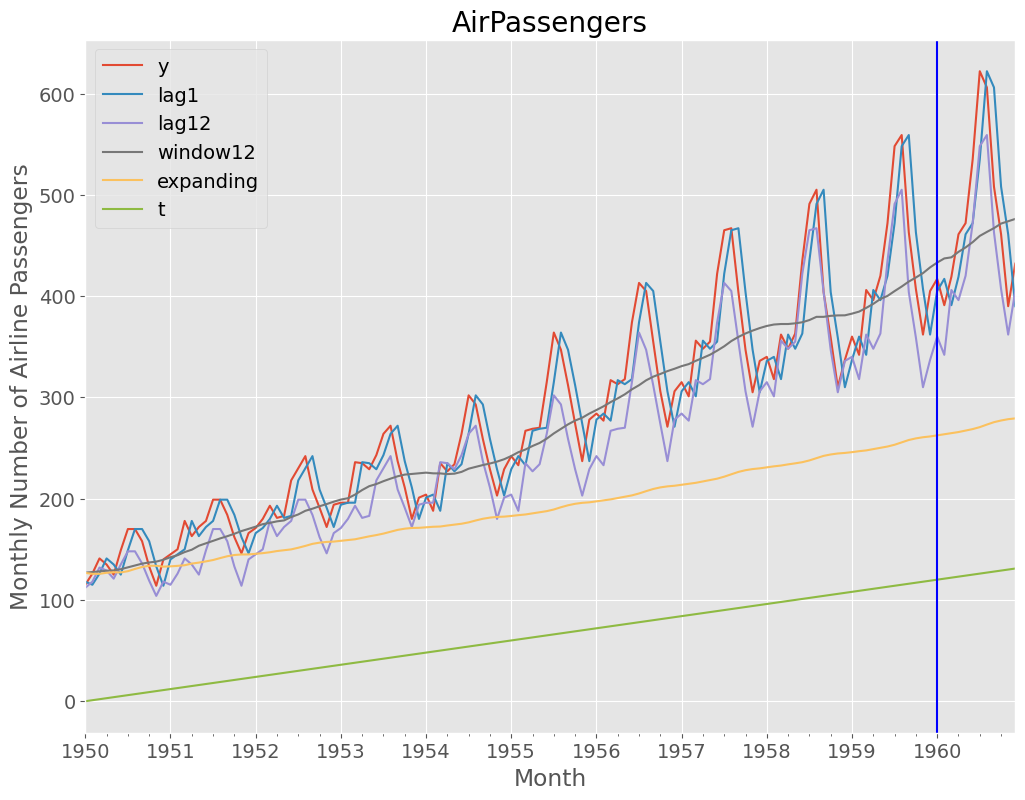

In [8]:
df.plot()
plt.title('AirPassengers')
plt.ylabel('Monthly Number of Airline Passengers')
plt.xlabel('Month')
plt.axvline(datetime.datetime(1960, 1, 1), color='blue')
plt.show()


In [9]:
# 分割
train, test = train_test_split(df, test_size=12)

y_train = train['y']
X_train = train.drop('y', axis=1)

y_test = test['y']
X_test = test.drop('y', axis=1)


### 予測モデルの学習とテスト

In [10]:
# モデルの学習

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print(f'切片: {regressor.intercept_}')
print(f'回帰係数: {regressor.coef_}')


切片: 268.7239972471469
回帰係数: [ 0.19938673  0.90244772  0.47122894 -2.6513727   1.72985199]


In [11]:
# 予測

# 学習期間
train_pred = regressor.predict(X_train)

# テスト期間
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag1_new = y_train_new.iloc[-1] #lag1
    lag12_new = y_train_new.iloc[-12] #lag12
    window12_new = y_train_new[-12:].mean() #window12
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test.iloc[(i+1):(i+2),0] = lag1_new
    X_test.iloc[(i+1):(i+2),1] = lag12_new
    X_test.iloc[(i+1):(i+2),2] = window12_new
    X_test.iloc[(i+1):(i+2),3] = expanding_new
    
# 予測値の代入
test_pred = y_train_new[-12:]
    
# 更新後の説明変数X
X_test


,lag1,lag12,window12,expanding,t
Month,,,,,
1960-01-01,405.000000,360.0,433.083333,262.492424,120
1960-02-01,390.055195,342.0,430.837933,277.016985,121
1960-03-01,332.993070,406.0,430.087355,277.475805,122
1960-04-01,379.531948,396.0,427.881684,278.305530,123
1960-05-01,378.277272,420.0,426.404790,279.111754,124
1960-06-01,398.582149,472.0,424.619970,280.067517,125
1960-07-01,447.912662,548.0,422.612691,281.399621,126
1960-08-01,523.586598,559.0,420.578241,283.306605,127
1960-09-01,544.316936,463.0,419.354652,285.345749,128


In [12]:
# 評価
print('RMSE:\n',
      np.sqrt(mean_squared_error(
          y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          y_test, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          y_test, test_pred))


RMSE:
 68.00246186452421
MAE:
 65.16326739451353
MAPE:
 0.13664194362050516


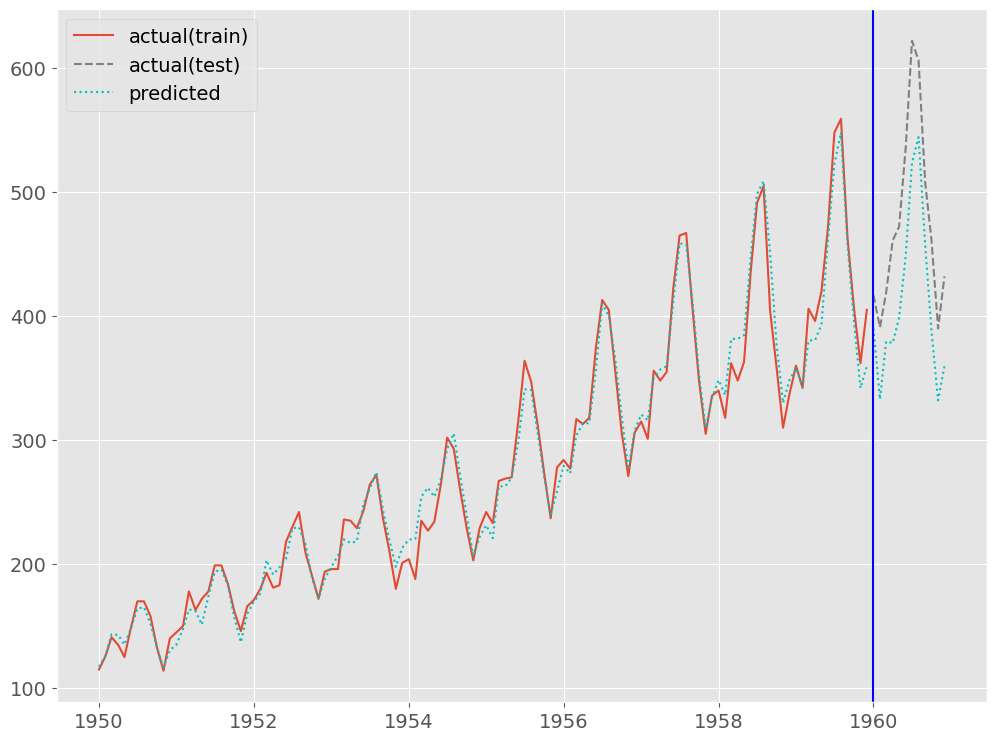

In [13]:
fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    train.index, 
    y_train, 
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    test.index, 
    y_test, 
    linestyle='--',
    label='actual(test)', 
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    train.index, 
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    test.index, 
    test_pred, 
    linestyle=':',
    label="predicted", 
    color="c") 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    datetime.datetime(1960,1,1),
    color='blue')

# 凡例表示
ax.legend()

plt.show()


## 3.3.10 線形回帰で予測モデルを構築（RFE法で特徴量選択）

In [14]:
from sklearn.feature_selection import RFECV

dataset_path = '../df_tbl.csv'
df = pd.read_csv(dataset_path, index_col='Month', parse_dates=True)


In [15]:
# データ分割
train, test = train_test_split(
    df, test_size=12)

# 学習データ
y_train = train['y']              #目的変数y
X_train = train.drop('y', axis=1) #説明変数X

# テストデータ
y_test = test['y']              #目的変数y
X_test = test.drop('y', axis=1) #説明変数X


### 変数選択（特徴量選択）

In [24]:
# インスタンスの生成
rfecv = RFECV(
    estimator=LinearRegression(),
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    cv=2
)

# 変数選択の実施
rfecv.fit(X_train, y_train)

# 選択された変数の表示
columns_selected = X_train.columns[rfecv.support_]
print(columns_selected.values)


['lag12' 'expanding' 't']


In [28]:
# 選択された変数のみのデータセットの作成
X_train_selected = X_train[columns_selected]
X_test_selected = X_test[columns_selected]


### モデルの学習と予測

In [29]:
regressor = LinearRegression()
regressor.fit(X_train_selected, y_train)

print(f'切片: {regressor.intercept_}')
print(f'回帰係数: {regressor.coef_}')


切片: 168.62590460330733
回帰係数: [ 1.05802825 -1.30758825  1.53925323]


In [31]:
# 予測の実施（学習期間）

train_pred = regressor.predict(X_train_selected)

# 予測の実施（テストデータ期間）

# 学習データのコピー
y_train_new = y_train.copy()

# 説明変数Xを更新しながら予測を実施
for i in range(len(y_test)):
    
    #当期の予測の実施
    X_value =  X_test_selected.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #次期の説明変数Xの計算
    lag12_new = y_train_new[-12] #lag12
    expanding_new = y_train_new.mean() #expanding
    
    #次期の説明変数Xの更新
    X_test_selected.iloc[(i+1):(i+2),0] = lag12_new
    X_test_selected.iloc[(i+1):(i+2),1] = expanding_new
    
# 予測値の代入
test_pred = y_train_new[-12:]
    


In [32]:
print('RMSE:\n',
      np.sqrt(mean_squared_error(
          y_test, test_pred)))
print('MAE:\n',
      mean_absolute_error(
          y_test, test_pred)) 
print('MAPE:\n',
      mean_absolute_percentage_error(
          y_test, test_pred))


RMSE:
 33.2955852068884
MAE:
 30.359167104903364
MAPE:
 0.06333890586216705


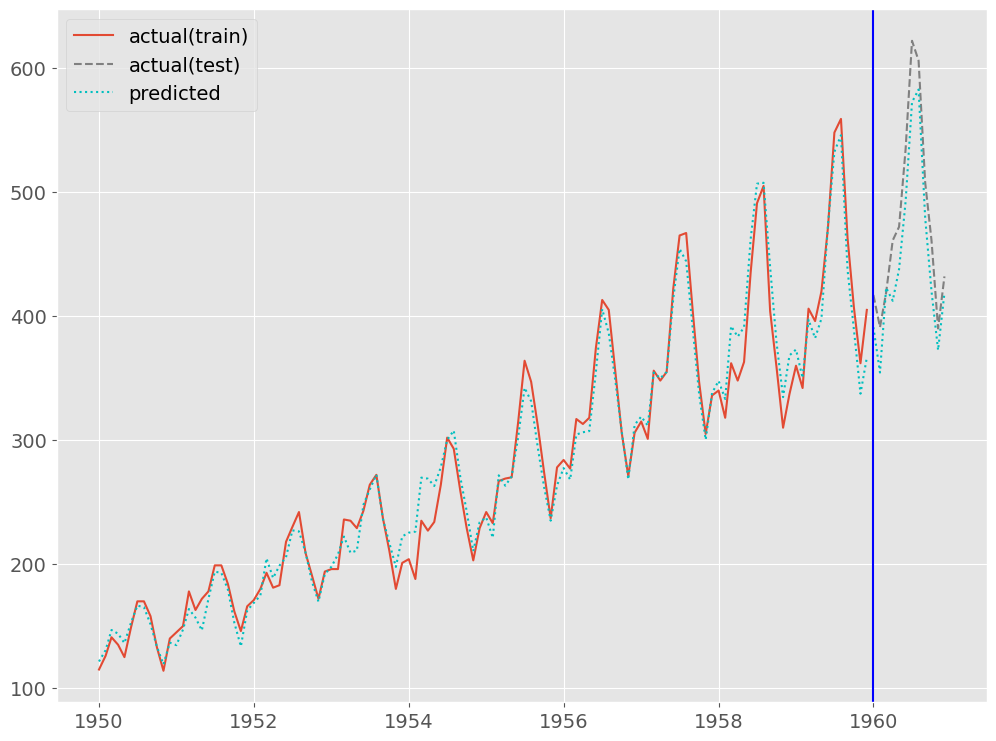

In [33]:
fig, ax = plt.subplots()

# 実測値の描写
## 学習データ
ax.plot(
    train.index, 
    y_train, 
    linestyle='-',
    label='actual(train)')

## テストデータ
ax.plot(
    test.index, 
    y_test, 
    linestyle='--',
    label='actual(test)', 
    color='gray')

# 予測値の描写
## 学習データ
ax.plot(
    train.index, 
    train_pred, 
    linestyle=':',
    color='c')

## テストデータ
ax.plot(
    test.index, 
    test_pred, 
    linestyle=':',
    label="predicted", 
    color="c") 

# 学習データとテスデータの間の縦線の描写
ax.axvline(
    datetime.datetime(1960,1,1),
    color='blue')

# 凡例表示
ax.legend()

plt.show()
